# Import libraries and data


In [33]:
#import libraries
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [41]:
#get the data
data = pd.read_csv("../Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [42]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)                       

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#Data Transformation

In [43]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [44]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#holidays

In [45]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [66]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

KeyError: "['holiday'] not found in axis"

#Training and Test Set

In [ ]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

#Facebook Prophet

In [48]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:15 - cmdstanpy - INFO - Chain [1] done processing


#forecasting 

In [54]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [55]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()


,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [56]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1780.496764,147.724017,1952.901292,1780.496764,1780.496764,-0.038444,-0.038444,-0.038444,-0.298982,...,0.00000,0.00000,0.00000,-0.272836,-0.272836,-0.272836,0.0,0.0,0.0,1002.363931
1,2011-01-02,1789.763748,-132.123518,1691.871935,1789.763748,1789.763748,-0.041680,-0.041680,-0.041680,-0.304567,...,0.00000,0.00000,0.00000,-0.265144,-0.265144,-0.265144,0.0,0.0,0.0,819.635948
2,2011-01-03,1799.030731,244.048657,1942.872955,1799.030731,1799.030731,-0.095468,-0.095468,-0.095468,-0.089509,...,0.13626,0.13626,0.13626,-0.256192,-0.256192,-0.256192,0.0,0.0,0.0,1073.840854
3,2011-01-04,1808.297715,285.454641,2114.117869,1808.297715,1808.297715,-0.088032,-0.088032,-0.088032,-0.081464,...,0.13626,0.13626,0.13626,-0.246096,-0.246096,-0.246096,0.0,0.0,0.0,1165.636609
4,2011-01-05,1817.564699,444.238459,2189.998230,1817.564699,1817.564699,-0.082420,-0.082420,-0.082420,-0.009818,...,0.13626,0.13626,0.13626,-0.234999,-0.234999,-0.234999,0.0,0.0,0.0,1307.242645


In [57]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4166.892016
701    3500.909854
702    5672.928312
703    5673.480501
704    5364.524803
Name: prophet, dtype: float64

#Visualization

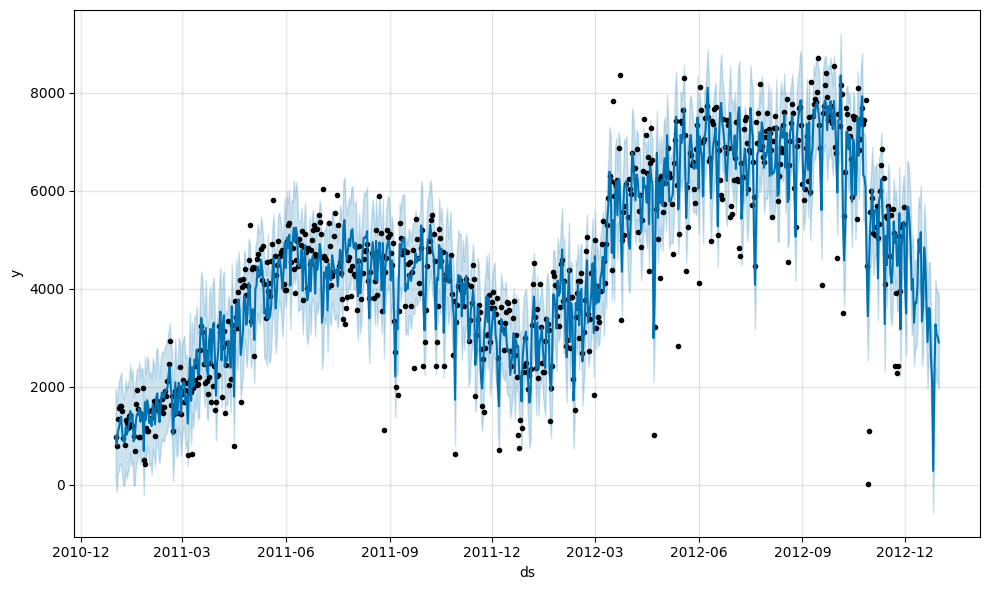

In [58]:
#visualization forecast
m.plot(forecast);

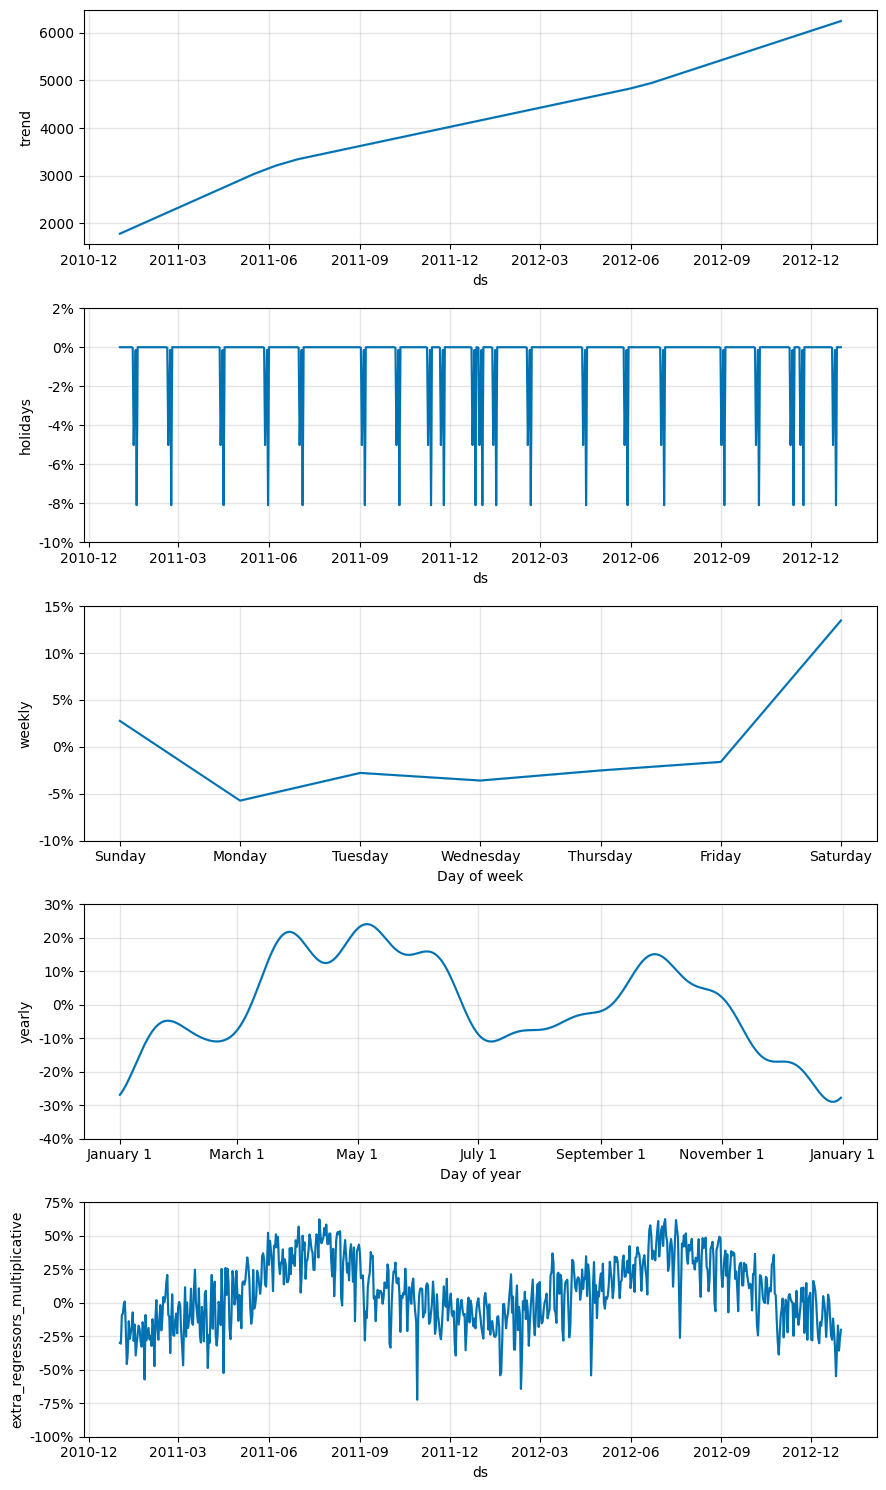

In [59]:
#plot components
m.plot_components(forecast);

#Model assessment

In [60]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

870.0
1035.0


In [61]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.86764681950873

# Cross-Validation

In [62]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
df_cv.head()

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:52:23 - cmdstanpy - INFO - Chain [1] start processing
16:52:23 - cmdstanpy - INFO - Chain [1] start processing
16:52:23 - cmdstanpy - INFO - Chain [1] start processing
16:52:23 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
16:52:24 - cmdstanpy - INFO - Ch

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8193.648016,7408.316466,8923.917897,5463,2012-06-28
1,2012-06-30,7245.835930,6473.927879,7996.070541,5687,2012-06-28
2,2012-07-01,7434.758617,6630.258679,8125.870545,5531,2012-06-28
3,2012-07-02,6781.455676,6011.018289,7508.173123,6227,2012-06-28
4,2012-07-03,7439.311854,6677.527413,8161.603544,6660,2012-06-28


In [63]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

1006.0
1265.0
126.96084241500618


#Hyperparameter tuning

In [64]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20]}
grid = ParameterGrid(param_grid)
list(grid)[:3]            

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [65]:
#Hyper parameter tuning
rmse = []
for params in grid:
  #build model
  m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('workingday')
  m.add_regressor('weathersit')
  m.add_regressor('temp')
  m.add_regressor('atemp')
  m.add_regressor('hum')
  m.add_regressor('windspeed')
  m.fit(training_set)

  #cross-validation
  df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
  
  #gather the results
  error = np.sqrt(mean_squared_error(df_cv['y'], 
                                     df_cv['yhat']))
  rmse.append(error)

16:52:42 - cmdstanpy - INFO - Chain [1] start processing
16:52:42 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:52:45 - cmdstanpy - INFO - Chain [1] start processing
16:52:45 - cmdstanpy - INFO - Chain [1] start processing
16:52:45 - cmdstanpy - INFO - Chain [1] start processing
16:52:45 - cmdstanpy - INFO - Chain [1] start processing
16:52:45 - cmdstanpy - INFO - Chain [1] done processing
16:52:45 - cmdstanpy - INFO - Chain [1] done processing
16:52:46 - cmdstanpy - INFO - Chain [1] done processing
16:52:46 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:48 - cmdstanpy - INFO - Ch

16:54:34 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:43 - cmdstanpy - INFO - Chain [1] done processing
16:54:43 - cmdstanpy - INFO - Chain [1] done processing
16:54:43 - cmdstanpy - INFO - Chain [1] done processing
16:54:44 - cmdstanpy - INFO - Chain [1] done processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
16:54:46 - cmdstanpy - INFO - Chain [1] start processing
16:54:46 - cmdstanpy - INFO - Ch

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:33 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:34 - cmdstanpy - INFO - Chain [1] done processing
16:56:34 - cmdstanpy - INFO - Cha

16:58:08 - cmdstanpy - INFO - Chain [1] start processing
16:58:08 - cmdstanpy - INFO - Chain [1] start processing
16:58:08 - cmdstanpy - INFO - Chain [1] start processing
16:58:08 - cmdstanpy - INFO - Chain [1] start processing
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
16:58:10 - cmdstanpy - INFO - Chain [1] done processing
16:58:10 - cmdstanpy - INFO - Chain [1] done processing
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
16:58:12 - cmdstanpy - INFO - Chain [1] done processing
16:58:13 - cmdstanpy - INFO - Chain [1] done processing
16:58:13 - cmdstanpy - INFO - Chain [1] done processing
16:58:13 - cmdstanpy - INFO - Chain [1] done processing
16:58:14 - cmdstanpy - INFO - Chain [1] start processing
16:58:14 - cmdstanpy - INFO - Chain [1]

16:59:56 - cmdstanpy - INFO - Chain [1] done processing
16:59:56 - cmdstanpy - INFO - Chain [1] done processing
16:59:57 - cmdstanpy - INFO - Chain [1] done processing
16:59:57 - cmdstanpy - INFO - Chain [1] done processing
16:59:58 - cmdstanpy - INFO - Chain [1] start processing
16:59:58 - cmdstanpy - INFO - Chain [1] start processing
16:59:58 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:00:00 - cmdstanpy - INFO - Chain [1] start processing
17:00:00 - cmdstanpy - INFO - Chain [1] done processing
17:00:02 - cmdstanpy - INFO - Chain [1] start processing
17:00:02 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plo

In [22]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 20, 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.01}


#Final Prophet Model

In [23]:
#build model
m = Prophet(growth = "linear",
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          holidays = holidays,
          seasonality_mode = "multiplicative",
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [30]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2479.028432,284.757208,2110.165002,2479.028432,2479.028432,-0.055322,-0.055322,-0.055322,-0.283330,...,0.000000,0.000000,0.000000,-0.271844,-0.271844,-0.271844,0.0,0.0,0.0,1233.526908
1,2011-01-02,2484.445087,58.027070,1850.003306,2484.445087,2484.445087,-0.059978,-0.059978,-0.059978,-0.291458,...,0.000000,0.000000,0.000000,-0.264227,-0.264227,-0.264227,0.0,0.0,0.0,994.496606
2,2011-01-03,2489.861742,469.703812,2248.715356,2489.861742,2489.861742,-0.137380,-0.137380,-0.137380,-0.200513,...,0.026831,0.026831,0.026831,-0.255242,-0.255242,-0.255242,0.0,0.0,0.0,1294.149203
3,2011-01-04,2495.278396,468.258382,2374.297267,2495.278396,2495.278396,-0.126680,-0.126680,-0.126680,-0.190845,...,0.026831,0.026831,0.026831,-0.245024,-0.245024,-0.245024,0.0,0.0,0.0,1410.610007
4,2011-01-05,2500.695051,619.210817,2503.976725,2500.695051,2500.695051,-0.118603,-0.118603,-0.118603,-0.121990,...,0.026831,0.026831,0.026831,-0.233732,-0.233732,-0.233732,0.0,0.0,0.0,1602.390154


In [31]:
#extract predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned.head()

ds
2012-12-01    4122.312137
2012-12-02    3503.082317
2012-12-03    5618.573978
2012-12-04    5598.117327
2012-12-05    5304.025376
Name: prophet_tuned, dtype: float64

#export forecasts

In [27]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

[Errno 2] No such file or directory: '/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble'
/Users/vipin/workspace/ai/my_own/Forecasting Models and Time Series for Business in Python 2/7. Facebook Prophet


In [28]:
predictions_prophet_tuned.to_csv('predictions_prophet_tuned.csv', index = True)